# Project Outline

This project looks at the stock price of Roku. By doing a time series analysis and also a sentiment analysis on social media for the stock price of Roku we will try and predict future prices.

Project flow:
 * Gather stock price (Gathering_Data notebook)
 * Gather posts from twitter and reddit (Gathering_Data notebook)
 * Clean up and do EDA (Gathering_Data notebook)
 * Do a sentiment analysis for each day (This notebook)
 * Do a time series analysis on both stock price and sentiment individually (This notebook)
 * Combine the sentiment and stock price to try and predict future prices (This notebook)

# Importing packages and loading data

In [5]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import twint
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import datetime as dt
import time
import re
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import pmdarima as pm
from statsmodels.graphics.gofplots import qqplot
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults 






pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [6]:
# Loading data
T_df = pd.read_csv('TwitterData.csv', header=None)
T_df.columns = ['id', 'date', 'timezone', 'tweet', 'language', 'cashtags', 
                'username', 'day', 'hour', 'nlikes', 'nreplies', 'nretweets', 'search']
R_df = pd.read_csv('redditdata.csv')
S_df = pd.read_csv('StockData.csv')

# Functions

In [7]:
# This function will remove emojis from the text

def RemoveEmojis(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [8]:
# This function is to run text through spacy/textblob pipeline
def Sentiment(text):
    
    #Initializing Sentiment analyzer
    SIA = SentimentIntensityAnalyzer()
    
    # Words to add to the sentiment lexicon
    new_words = {
        'bullish': 3.4,
        'bull':3.4,
        'long':3.4,
        'longs':3.4,
        'Holding':3.4,
        'holding':3.4,
        'Hodl':3.4,
        'hodl':3.4,
        'Call':3.4,
        'Calls':3.4,
        'call':3.4,
        'calls':3.4,
        'Put':-3.9,
        'Puts':-3.9,
        'put':-3.9,
        'puts':-3.9,
        'bear':-3.9,
        'bearish':-3.9,
        'short': -3.9,
        'shorts':-3.9
        }

    # Updating lexicon
    SIA.lexicon.update(new_words)
    
    # Running
    output = SIA.polarity_scores(text)
    
    return output['compound']

In [9]:
# This function will calculate the mse

def mse_calc(data, prediction, start, column):
    y_hat = prediction.predicted_mean
    real_values = data[start:][column]
    mse = ((real_values-y_hat)**2).mean()
    return mse

In [10]:
# This function will plot the timeseries and the predicted values from the model

def PlotPredictions(obs_data, pred_data, pred_data_conf, figsize=(15,8), beg='2013', title='title'):
    
    plt.figure(figsize=figsize)
    
    # Plot observed values
    ax = obs_data[beg:].plot(label='Observed')

    # Plot predicted values
    pred_data.predicted_mean.plot(ax=ax)

    # Plot the range for confidence intervals
    ax.fill_between(pred_data_conf.index,
                pred_data_conf.iloc[:, 0],
                pred_data_conf.iloc[:, 1], color='g', alpha=0.1)

    # Set axes labels
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    plt.show()

In [11]:
# This function is used to try different sets of parameters for SARIMAX
# It will return a dataframe with the parameters and the aic values

def Grid_Auto_bot(data, order_list):

    # Initializing an empty list for storing results
    results=[]

    # Going through and creating a model using all combinations of order
    # Also outputing order/aic score to a list
    for comb in order_list:
        try:
            mod = ARIMA(data, order = comb, freq='B')
            output = mod.fit()
            results.append([comb,ARIMAResults.aic(output)])
            print('ARIMA {} : AIC Calculated ={}'.format(comb, ARIMAResults.aic(output)))
             
        except:
            continue
                
    # Creating a dataframe for the results
    ans_df = pd.DataFrame(results, columns=['pdq','aic'])
    
    # Making aic column into numeric
    ans_df['aic'] = pd.to_numeric(ans_df['aic'])
    
    return ans_df

In [12]:
# This function is used to do a final SARIMAX modeling on the chosen parameters
# It will return useful information about the model and prediction that will
# be put into a dataframe later on.

def Final_Model_Check(train, test, order, seasonal_order, beg='2017', train_check_start='2021-02-01',
            train_check_end='2021-03-31', final_check_start='2021-04-01',
            final_check_end='2021-05-31', future=30):
    
    
    # Making the train SARIMAX model
    Train_model = SARIMAX(train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    train_output = Train_model.fit()
    
    # Shows the train model summary
    print('Train_model summary')
    display(train_output.summary());
    
    # Getting One Step prediction to check train model
    train_prediction = train_output.get_prediction(start=train_check_start,
                                           end=train_check_end,
                                           dynamic=False)
    train_prediction_conf = train_prediction.conf_int()
    
    # Getting dynamic prediction to check train model
    train_prediction_dyn = train_output.get_prediction(start=train_check_start, 
                                                     end=train_check_end, 
                                                     dynamic=True)
    train_prediction_dyn_conf = train_prediction_dyn.conf_int()
    
    #Getting forecast to see how well the train model does compared to the test data
    train_forecast = train_output.get_forecast(steps = 42)
    train_forecast_conf = train_forecast.conf_int()
    
    # Shows the diagnostics for the train model
    train_output.plot_diagnostics();
    
    # Plots the predictions from the train model
    PlotPredictions(obs_data=train,
                    beg=beg,
                    pred_data=train_prediction, 
                    pred_data_conf=train_prediction_conf,
                    title='Train one step prediction')
    PlotPredictions(obs_data=data, 
                    beg=beg,
                    pred_data=train_prediction_dyn, 
                    pred_data_conf=train_prediction_dyn_conf,
                    title='Train dynamic prediction')
    PlotPredictions(obs_data=data, 
                    beg=beg,
                    pred_data=train_forecast, 
                    pred_data_conf=train_forecast_conf,
                    title='Train forecasted test prediction')

        
    # Calculating MSE for all predictions/forecast for train model
    train_mse = mse_calc(data=train, prediction=train_prediction, 
                         start=train_check_start)
    train_dyn_mse = mse_calc(data=train, prediction=train_prediction_dyn, 
                             start=train_check_start)
    train_forecast_mse = mse_calc(data=data, prediction=train_forecast, 
                                  start=final_check_start)
    train_forecast_rmse = np.sqrt(train_forecast_mse)
    
    
    # Final model that's going to predict the future using both train + test
    Final_model = SARIMAX(data['value'].astype('int'),
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    Final_output = Final_model.fit()
    
    # Shows the final models summary
    print('Final_output summary')
    display(Final_output.summary());
 

    # Getting One Step prediction to check Final model
    final_prediction = Final_output.get_prediction(start=final_check_start,
                                           end=final_check_end,
                                           dynamic=False)
    final_prediction_conf = final_prediction.conf_int()
    
    # Getting dynamic prediction to check Final model
    final_prediction_dyn = Final_output.get_prediction(start=final_check_start, 
                                                     end=final_check_end, 
                                                     dynamic=True)
    final_prediction_dyn_conf = final_prediction_dyn.conf_int()
    
    #Getting future forecast for the final model
    final_forecast = Final_output.get_forecast(steps = future)
    final_forecast_conf = final_forecast.conf_int()

    
    # Calculating MSE for all predictions for final model
    final_mse = mse_calc(data=data, prediction=final_prediction, 
                         start=final_check_start)
    final_dyn_mse = mse_calc(data=data, prediction=final_prediction_dyn, 
                             start=final_check_start)
    final_dyn_rmse = np.sqrt(final_dyn_mse)
    
    # Shows the diagnostics for the final model
    Final_output.plot_diagnostics();
    
    # Plots the future predictions for the final model
    PlotPredictions(obs_data=data,
                    beg=beg,
                    pred_data=final_forecast, 
                    pred_data_conf=final_forecast_conf,
                    title='Final forecast')
    
    
    return [order, seasonal_order, train_mse, train_dyn_mse, train_forecast_mse,
            train_forecast_rmse, final_mse, final_dyn_mse, final_dyn_rmse,
            data.loc[final_check_end]['value'], final_forecast.predicted_mean[-1],
            final_forecast_conf.iloc[-1,0], final_forecast_conf.iloc[-1,1]]

# Clean up and EDA

## Clean up Twitter EDA

In [13]:
print(T_df.shape)
T_df.head()

(666, 13)


,id,date,timezone,tweet,language,cashtags,username,day,hour,nlikes,nreplies,nretweets,search
0,913765506456473600,2017-09-29 09:00:48,-500,"$1900 in 10 minutes on $ROKU, so glad the mark...",en,['roku'],eatsleepprofit,5,9,69,8,2,$ROKU
1,913841066473869313,2017-09-29 14:01:03,-500,$ROKU is already up almost 100% since its IPO....,en,['roku'],Stocktwits,5,14,40,5,23,$ROKU
2,914147418316398592,2017-09-30 10:18:23,-500,Mystified by $ROKU's IPO? @JimCramer's breakin...,en,['roku'],MadMoneyOnCNBC,6,10,29,5,11,$ROKU
3,913892627845570560,2017-09-29 17:25:56,-500,"$ROKU Long. One Ticker, a few trades. Couldve ...",en,['roku'],SmashTheBid,5,17,28,4,0,$ROKU
4,913843670872444928,2017-09-29 14:11:24,-500,Love #Pennystocks Nice Friday for my 2 account...,en,"['vcel', 'izea', 'gluu', 'roku']",EbogeyEd,5,14,24,1,3,$ROKU


In [14]:
# Making date in dataframe just the date and no time
T_df['date'] = T_df.date.apply(lambda x: x.split(' ',1)[0])

# Dropping any scraped entries that aren't english
T_df.drop(T_df[T_df['language'] != 'en'].index, inplace = True)

# Only keeping date and tweet
T_df = T_df[['date','tweet']]

In [15]:
# Removing any url links
T_df['tweet_LinkRemoved'] = T_df.tweet.apply(
    lambda x: re.sub(r'https\S+', '', x))

# Removing any emojis
T_df['tweet_Link+Emoji_Removed'] = T_df.tweet_LinkRemoved.apply(
    lambda x: RemoveEmojis(x))

# Change things to lower case
T_df['tweet_cleaned_lowercase'] = T_df['tweet_Link+Emoji_Removed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

# Remove punctuations
T_df['tweet_cleaned_lower_NoPunct'] = T_df['tweet_cleaned_lowercase'].str.replace(
    '[^\w\s]', '')

# Remove stopwards
stop = stopwords.words('english')
T_df['tweet_FinalClean'] = T_df['tweet_cleaned_lower_NoPunct'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

## Clean up Reddit

In [16]:
R_df.head()

,ID,Num_Comments,Score,Subreddit,Title,Upvote_Ratio,Created,Created_utc,Self_text,Date
0,730n8l,50,113,investing,ROKU up 28% shortly after IPO,0.91,1.506640e+09,1.506611e+09,http://www.hollywoodreporter.com/news/roku-sto...,2017-09-28
1,72ztnr,0,35,stocks,9/28 Thursday Stock Market Movers & News,0.89,1.506631e+09,1.506603e+09,#Good morning traders of the r/stocks sub! Hap...,2017-09-28
2,730zps,31,26,wallstreetbets,WHEN TO SHORT ROKU,0.85,1.506643e+09,1.506614e+09,"this company does nothing new, i think 24~ SHO...",2017-09-28
3,7314h8,37,20,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,0.95,1.506644e+09,1.506615e+09,NaN,2017-09-28
4,730jwz,33,14,wallstreetbets,"$ROKU IPO, to the moon...?",0.90,1.506639e+09,1.506610e+09,Why isn't this thing available on my POS broke...,2017-09-28


In [17]:
# The things we care about are date, subreddit, title, and self_text
R_df = R_df[['Date','Subreddit','Title','Self_text']]

# Combining the title and self text
R_df['Self_text'] = R_df['Self_text'].fillna('.')
R_df['Combined_text'] = R_df['Title'] + ' ' + R_df['Self_text']

In [18]:
# Removing any links
R_df['Combined_text_LinksRemoved'] = R_df.Combined_text.apply(
    lambda x: re.sub(r'https\S+', '', x))
R_df['Combined_text_LinksRemoved'] = R_df.Combined_text_LinksRemoved.apply(
    lambda x: re.sub(r'http\S+', '', x))

# Removing any emojis
R_df['Combined_text_Link+Emoji_Removed'] = R_df.Combined_text_LinksRemoved.apply(lambda x: RemoveEmojis(x))

# Change things to lower case
R_df['Combined_text_cleaned_lowercase'] = R_df['Combined_text_Link+Emoji_Removed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

# Remove punctuations
R_df['Combined_text_cleaned_lower_NoPunct'] = R_df['Combined_text_cleaned_lowercase'].str.replace(
    '[^\w\s]', '')

# Remove stopwards
stop = stopwords.words('english')
R_df['Combined_text_FinalClean'] = R_df['Combined_text_cleaned_lower_NoPunct'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

In [19]:
R_df

,Date,Subreddit,Title,Self_text,Combined_text,Combined_text_LinksRemoved,Combined_text_Link+Emoji_Removed,Combined_text_cleaned_lowercase,Combined_text_cleaned_lower_NoPunct,Combined_text_FinalClean
0,2017-09-28,investing,ROKU up 28% shortly after IPO,http://www.hollywoodreporter.com/news/roku-sto...,ROKU up 28% shortly after IPO http://www.holly...,ROKU up 28% shortly after IPO \n\n>The video s...,ROKU up 28% shortly after IPO \n\n>The video s...,roku up 28% shortly after ipo >the video strea...,roku up 28 shortly after ipo the video streami...,roku 28 shortly ipo video streaming device mak...
1,2017-09-28,stocks,9/28 Thursday Stock Market Movers & News,#Good morning traders of the r/stocks sub! Hap...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 thursday stock market movers & news #good...,928 thursday stock market movers news good mo...,928 thursday stock market movers news good mor...
2,2017-09-28,wallstreetbets,WHEN TO SHORT ROKU,"this company does nothing new, i think 24~ SHO...",WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,when to short roku this company does nothing n...,when to short roku this company does nothing n...,short roku company nothing new think 24 short ...
3,2017-09-28,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,.,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,roku now listex on nasdaq. up 35% so far .,roku now listex on nasdaq up 35 so far,roku listex nasdaq 35 far
4,2017-09-28,wallstreetbets,"$ROKU IPO, to the moon...?",Why isn't this thing available on my POS broke...,"$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$roku ipo, to the moon...? why isn't this thin...",roku ipo to the moon why isnt this thing avail...,roku ipo moon isnt thing available pos brokers
...,...,...,...,...,...,...,...,...,...,...
613,2021-05-11,wallstreetbets,"$FUBO - Archegos, Misreported Earnings, and th...",Reporting AH ( 45 mins ) so i dont have much t...,"$FUBO - Archegos, Misreported Earnings, and th...","$FUBO - Archegos, Misreported Earnings, and th...","$FUBO - Archegos, Misreported Earnings, and th...","$fubo - archegos, misreported earnings, and th...",fubo archegos misreported earnings and the qu...,fubo archegos misreported earnings quiet perio...
614,2021-05-12,investing,Best Dip Stocks to buy right now,"Hey y'all,\n\nI have alot of cash lying around...","Best Dip Stocks to buy right now Hey y'all,\n\...","Best Dip Stocks to buy right now Hey y'all,\n\...","Best Dip Stocks to buy right now Hey y'all,\n\...","best dip stocks to buy right now hey y'all, i ...",best dip stocks to buy right now hey yall i ha...,best dip stocks buy right hey yall alot cash l...
615,2021-05-13,Daytrading,"The Only Watch List You Need May 13, 2021",*The original Gap Watch List Poster! The one t...,"The Only Watch List You Need May 13, 2021 *The...","The Only Watch List You Need May 13, 2021 *The...","The Only Watch List You Need May 13, 2021 *The...","the only watch list you need may 13, 2021 *the...",the only watch list you need may 13 2021 the o...,watch list need may 13 2021 original gap watch...
616,2021-05-20,wallstreetbets,PUBM DD #1,\n\nA little bit about myself for context:\n\...,PUBM DD #1 \n\nA little bit about myself for ...,PUBM DD #1 \n\nA little bit about myself for ...,PUBM DD #1 \n\nA little bit about myself for ...,pubm dd #1 a little bit about myself for conte...,pubm dd 1 a little bit about myself for contex...,pubm dd 1 little bit context 1 work enterprise...


In [20]:
R_df.iloc[0]['Combined_text_LinksRemoved']

'ROKU up 28% shortly after IPO \n\n>The video streaming device maker had late Wednesday set its initial public offering price at $14 per share, or a market value of $1.3 billion.\n\n>The stock of video streaming device maker Roku rose in its stock market debut on Thursday. It opened just after 10:35 a.m. ET at $15.78, up 12.7 percent.\n\n>About 10 minutes later, it was up 28 percent at $17.94.\n\n>The company had recently filed for an initial public offering and late Wednesday had set its IPO price at $14 per share, which raised about $219 million and made for a market value of $1.3 billion.\n\n>The  Los Gatos, Calif.-based company, which makes TV set-top boxes and other devices, listed its stock on the Nasdaq under the ticker symbol ROKU. Its filing have shown that Roku lost $42.8 million in 2016 on nearly $399 million in revenue, up 25 percent from 2015.\n\n>Roku, led by CEO Anthony Wood, has also disclosed that its users streamed more than 6.7 billion hours of programming on its pla

# Exploring sentiment analysis, Vader

In [21]:
# Figuring out the max and min of the scores in the lexicon
SIA = SentimentIntensityAnalyzer()

maxi = 0
mini = 0

for k,v in SIA.lexicon.items():

    if v > maxi:
        maxi = v
    if v < mini:
        mini = v
        
print('Maximum points for a word/emoticon', maxi)
print('Minimum points for a word/emoticon', mini)

Maximum points for a word/emoticon 3.4
Minimum points for a word/emoticon -3.9


Added custom words with scores as either the maximum or minimum in the Sentiment Function located earlier in the notebook. Vader can take in emoji's, going to try a tweet examples with an emoji and without the emojis to see which one is more accurate.

In [22]:
# Tweet with the links removed
T_df.iloc[0]['tweet_LinkRemoved']

"$1900 in 10 minutes on $ROKU, so glad the market is picking up with multiple runners literally everyday. I really hope this doesn't stop🙏🏼😁  "

In [23]:
print('Score with the emoji: ',Sentiment(T_df.iloc[0]['tweet_LinkRemoved']))
print('Score without the emoji: ',Sentiment(T_df.iloc[0]['tweet_Link+Emoji_Removed']))

Score with the emoji:  0.8989
Score without the emoji:  0.838


It looks like the tweet with the emoji is more accurate, for future sentiment analysis the emoji's will be used in the text.

# Combining Reddit and Twitter Data

In [24]:
T_df.head()

,date,tweet,tweet_LinkRemoved,tweet_Link+Emoji_Removed,tweet_cleaned_lowercase,tweet_cleaned_lower_NoPunct,tweet_FinalClean
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $roku, so glad the mark...",1900 in 10 minutes on roku so glad the market ...,1900 10 minutes roku glad market picking multi...
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,$ROKU is already up almost 100% since its IPO....,$ROKU is already up almost 100% since its IPO....,$roku is already up almost 100% since its ipo....,roku is already up almost 100 since its ipo he...,roku already almost 100 since ipo heres went p...
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,Mystified by $ROKU's IPO? @JimCramer's breakin...,Mystified by $ROKU's IPO? @JimCramer's breakin...,mystified by $roku's ipo? @jimcramer's breakin...,mystified by rokus ipo jimcramers breaking it ...,mystified rokus ipo jimcramers breaking
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...","$ROKU Long. One Ticker, a few trades. Couldve ...","$ROKU Long. One Ticker, a few trades. Couldve ...","$roku long. one ticker, a few trades. couldve ...",roku long one ticker a few trades couldve done...,roku long one ticker trades couldve done lot b...
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,Love #Pennystocks Nice Friday for my 2 account...,Love #Pennystocks Nice Friday for my 2 account...,love #pennystocks nice friday for my 2 account...,love pennystocks nice friday for my 2 accounts...,love pennystocks nice friday 2 accounts 1200 v...


In [25]:
R_df.head()

,Date,Subreddit,Title,Self_text,Combined_text,Combined_text_LinksRemoved,Combined_text_Link+Emoji_Removed,Combined_text_cleaned_lowercase,Combined_text_cleaned_lower_NoPunct,Combined_text_FinalClean
0,2017-09-28,investing,ROKU up 28% shortly after IPO,http://www.hollywoodreporter.com/news/roku-sto...,ROKU up 28% shortly after IPO http://www.holly...,ROKU up 28% shortly after IPO \n\n>The video s...,ROKU up 28% shortly after IPO \n\n>The video s...,roku up 28% shortly after ipo >the video strea...,roku up 28 shortly after ipo the video streami...,roku 28 shortly ipo video streaming device mak...
1,2017-09-28,stocks,9/28 Thursday Stock Market Movers & News,#Good morning traders of the r/stocks sub! Hap...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 thursday stock market movers & news #good...,928 thursday stock market movers news good mo...,928 thursday stock market movers news good mor...
2,2017-09-28,wallstreetbets,WHEN TO SHORT ROKU,"this company does nothing new, i think 24~ SHO...",WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,when to short roku this company does nothing n...,when to short roku this company does nothing n...,short roku company nothing new think 24 short ...
3,2017-09-28,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,.,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,roku now listex on nasdaq. up 35% so far .,roku now listex on nasdaq up 35 so far,roku listex nasdaq 35 far
4,2017-09-28,wallstreetbets,"$ROKU IPO, to the moon...?",Why isn't this thing available on my POS broke...,"$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$roku ipo, to the moon...? why isn't this thin...",roku ipo to the moon why isnt this thing avail...,roku ipo moon isnt thing available pos brokers


In [26]:
# Combining the Twitter dataframe and the Reddit Dataframe
temp_T_df = T_df[['date','tweet_LinkRemoved']].copy()
temp_T_df.columns = ['Date','Text']

temp_R_df = R_df[['Date','Combined_text_LinksRemoved']].copy()
temp_R_df.columns = ['Date','Text']

Sentiment_df = pd.concat([temp_T_df,temp_R_df])

In [27]:
print('Check to see if combination worked.')
print('Twitter dataframe number of entries: ', len(T_df))
print('Reddit dataframe number of entries: ', len(R_df))
print('Combined dataframe number of entries: ', len(Sentiment_df))

Check to see if combination worked.
Twitter dataframe number of entries:  565
Reddit dataframe number of entries:  618
Combined dataframe number of entries:  1183


# Running the sentiment function to find sentiment scores

In [28]:
Sentiment_df['Score'] = Sentiment_df.Text.apply(lambda x: Sentiment(x))

In [29]:
Sentiment_df

,Date,Text,Score
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...",0.8989
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0000
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0000
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...",0.5647
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,0.9222
...,...,...,...
613,2021-05-11,"$FUBO - Archegos, Misreported Earnings, and th...",0.8991
614,2021-05-12,"Best Dip Stocks to buy right now Hey y'all,\n\...",0.9050
615,2021-05-13,"The Only Watch List You Need May 13, 2021 *The...",0.9868
616,2021-05-20,PUBM DD #1 \n\nA little bit about myself for ...,0.9992


In [30]:
Text_to_check = Sentiment_df[Sentiment_df['Score'] == 0]
Text_to_check

,Date,Text,Score
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0
15,2017-12-08,$ROKU Next week there will be a big storm in S...,0.0
23,2017-12-22,First time since after $ROKU earnings in Nov n...,0.0
24,2017-12-30,"Oh, what a year. 📈 #BestOf2017 stocks from IB...",0.0
...,...,...,...
478,2020-12-01,$ROKU I can’t quit you .,0.0
502,2020-12-24,"Finally upgraded to the next leve(nio, Roku, e...",0.0
512,2021-01-05,Quibi Selling Catalog To Roku: Report .,0.0
531,2021-01-20,$NFLX $DIS $ROKU Streaming Services Comparison...,0.0


In [31]:
print('Texts from ',len(Text_to_check),' had a sentiment score of 0 (they analyzer did not understand or they were neutral).')
print('That is ', len(Text_to_check)/len(Sentiment_df)*100,'% of the entries we have.')

Texts from  173  had a sentiment score of 0 (they analyzer did not understand or they were neutral).
That is  14.623837700760777 % of the entries we have.


# Combining the scores for each day and combining all data to one dataframe

In [32]:
Sentiment_df.head()

,Date,Text,Score
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...",0.8989
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0000
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0000
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...",0.5647
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,0.9222


In [33]:
Avg_Sentiment_df = Sentiment_df.groupby(['Date']).mean()

In [34]:
Avg_Sentiment_df.head()

,Score
Date,
2017-09-28,0.185700
2017-09-29,0.457833
2017-09-30,0.000000
2017-10-02,-0.094050
2017-10-05,-0.011300


In [35]:
len(Avg_Sentiment_df)

519

In [36]:
len(S_df)

923

In [37]:
S_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-28,15.800000,23.500000,15.750000,23.500000,23.500000,39265900
1,2017-09-29,26.740000,29.799999,25.469999,26.540001,26.540001,44294700
2,2017-10-02,25.200001,26.280001,23.260000,23.559999,23.559999,16008400
3,2017-10-03,23.010000,23.020000,20.770000,20.809999,20.809999,13678500
4,2017-10-04,21.290001,22.600000,20.820000,20.850000,20.850000,9345700


In [38]:
S_df_closing = S_df[['Date','Close']]
S_df_closing.head()

,Date,Close
0,2017-09-28,23.500000
1,2017-09-29,26.540001
2,2017-10-02,23.559999
3,2017-10-03,20.809999
4,2017-10-04,20.850000


In [39]:
Final_df = pd.merge(left=S_df_closing, right=Avg_Sentiment_df, how='left', left_on='Date', right_on='Date')
Final_df.columns = ['Date','Close','Sentiment_Score']
Final_df['Date'] = pd.to_datetime(Final_df['Date'])
Final_df.set_index('Date', inplace=True)
Final_df = Final_df.asfreq('B', method='ffill')
Final_df

,Close,Sentiment_Score
Date,,
2017-09-28,23.500000,0.185700
2017-09-29,26.540001,0.457833
2017-10-02,23.559999,-0.094050
2017-10-03,20.809999,NaN
2017-10-04,20.850000,NaN
...,...,...
2021-05-24,347.220001,NaN
2021-05-25,345.700012,0.986600
2021-05-26,348.989990,NaN


In [40]:
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 957 entries, 2017-09-28 to 2021-05-28
Freq: B
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close            957 non-null    float64
 1   Sentiment_Score  449 non-null    float64
dtypes: float64(2)
memory usage: 22.4 KB


In [41]:
Final_df.Close.isna().sum()

0

In [42]:
Final_df.head(75)

,Close,Sentiment_Score
Date,,
2017-09-28,23.500000,0.185700
2017-09-29,26.540001,0.457833
2017-10-02,23.559999,-0.094050
2017-10-03,20.809999,NaN
2017-10-04,20.850000,NaN
2017-10-05,22.010000,-0.011300
2017-10-06,23.200001,NaN
2017-10-09,24.540001,-0.938800
2017-10-10,22.930000,0.000000


Going to fill missing sentiment data by taking a gradient from last known sentiment to the next known sentiment.

In [43]:
Final_df['Sentiment_Score_LinearFill'] = Final_df['Sentiment_Score'].interpolate(method='linear')

In [44]:
# Making a logged closing cost since the data will most likely follow an exponential trend
Final_df['Close_logged'] = np.log(Final_df['Close'])

In [45]:
Final_df.tail(5)

,Close,Sentiment_Score,Sentiment_Score_LinearFill,Close_logged
Date,,,,
2021-05-24,347.220001,NaN,0.624075,5.849959
2021-05-25,345.700012,0.9866,0.986600,5.845571
2021-05-26,348.989990,NaN,0.789500,5.855043
2021-05-27,349.029999,NaN,0.592400,5.855158
2021-05-28,346.709991,0.3953,0.395300,5.848489


# Time series analysis for Stock Data

## Train test split, looking at original plot

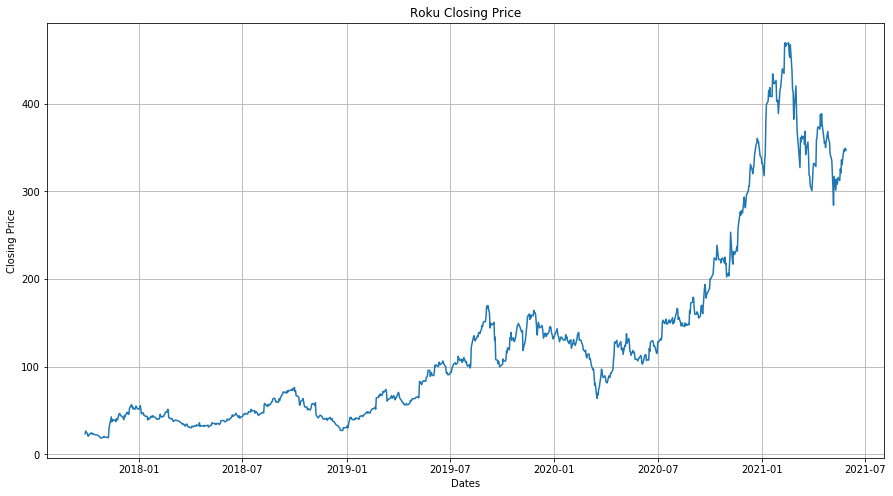

In [46]:
plt.figure(figsize = (15,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.plot(Final_df['Close'])
plt.title('Roku Closing Price')
plt.show()

In [98]:
# Train Test Split (Making testing data the last month)
Train, Test = train_test_split(Final_df, test_size=20)

In [99]:
Test

,Close,Sentiment_Score,Sentiment_Score_LinearFill,Close_logged
Date,,,,
2021-05-03,335.309998,0.99640,0.996400,5.815055
2021-05-04,319.589996,NaN,0.626367,5.767039
2021-05-05,304.170013,NaN,0.256333,5.717587
2021-05-06,284.179993,-0.11370,-0.113700,5.649608
2021-05-07,317.000000,0.20215,0.202150,5.758902
2021-05-10,301.410004,NaN,0.550625,5.708471
2021-05-11,314.119995,0.89910,0.899100,5.749775
2021-05-12,308.029999,0.90500,0.905000,5.730197
2021-05-13,309.600006,0.87210,0.872100,5.735281


In [100]:
print('Train set has', len(Train),'entries.')
print('Test set has', len(Test),'entries.')

Train set has 937 entries.
Test set has 20 entries.


## Looking at seasonality using Seasonal Decompose

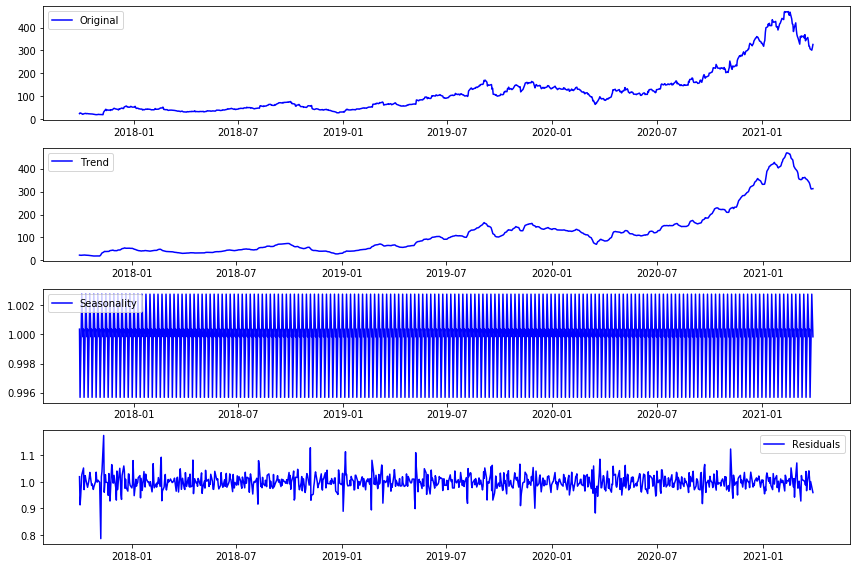

In [50]:
# Taking the decomposition of Roku Stock, the original plot sugests a multiplicative trend.
decomposition = seasonal_decompose(Train['Close'], model='multiplicative')

# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the original data
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Train['Close'], label='Original', color='blue')
plt.legend(loc='best')

# Plotting the Trend of the data
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')

# Plotting the Seasonality of the data
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')

# Plotting the Residuals of the data
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [51]:
seasonal

Date
2017-09-28    1.000366
2017-09-29    0.995681
2017-10-02    1.002772
2017-10-03    1.001338
2017-10-04    0.999843
                ...   
2021-03-25    1.000366
2021-03-26    0.995681
2021-03-29    1.002772
2021-03-30    1.001338
2021-03-31    0.999843
Freq: B, Name: Close, Length: 915, dtype: float64

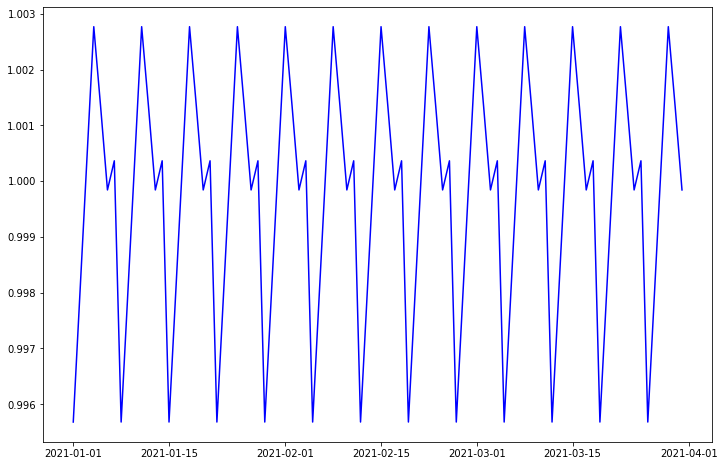

In [52]:
# Zoom up on seasonal trends
plt.figure(figsize=(12,8))
plt.plot(seasonal['2021':], label='Original', color='blue')
plt.show()

The time difference between the two minimums is 7 days 00:00:00


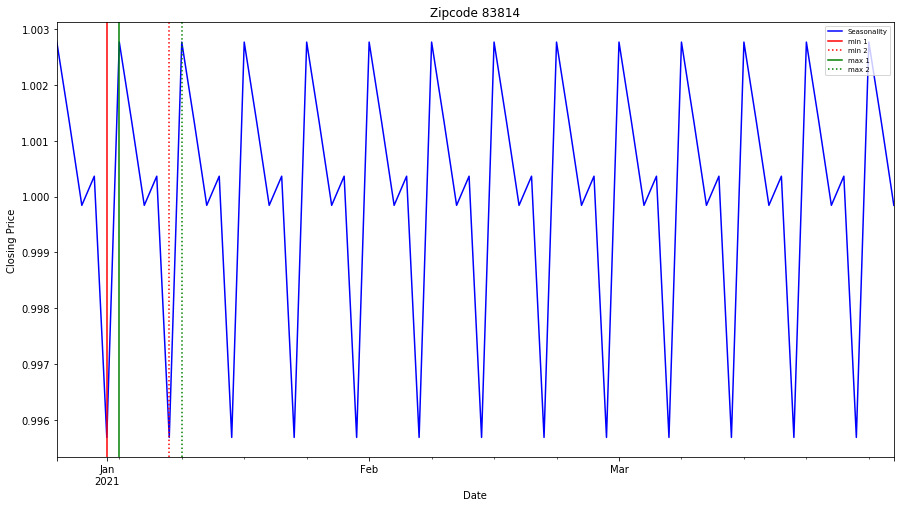

In [53]:
# Looking at the seasonal plot closer
plt.figure(figsize=(15,8))

# Plotting the seasonality plot
ax = seasonal['2020-12-27':].plot(label='Seasonality', color='blue')

# Finding the time stamps of the mins and maxs
min_ = seasonal['2021':].idxmin()
max_ = seasonal['2021':].idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()

# Adding verticle lines for the mins/maxs
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')

# Graph properties
plt.legend(loc='upper right', fontsize='x-small')
plt.xlabel('Date')
plt.title('Roku')
plt.ylabel('Closing Price')

print(f'The time difference between the two minimums is {min_2-min_}')

The seasonality seems to happen every week, however the change in price is very miniscule. The seasonality factor can most likely be ignored.

## Finding Model Parameters

### Auto Arima on raw data

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5953.896, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5954.312, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5954.458, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5954.434, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5957.099, Time=0.46 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.926 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  915
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2974.948
Date:                Fri, 18 Jun 2021   AIC                           5953.896
Time:                        17:02:09   BIC                           5963.531
Sample:                             0   HQIC                          5957.574
                                - 915                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3307      0.207      1.594      0.111      -0.076       0.737
sigma2        39.3248      0.794     49.548      0.000      37.769      40.880
===================================================================================
Ljung-Box (Q):                       89.07   Jarque-Bera (JB):              2916.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              17.05   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

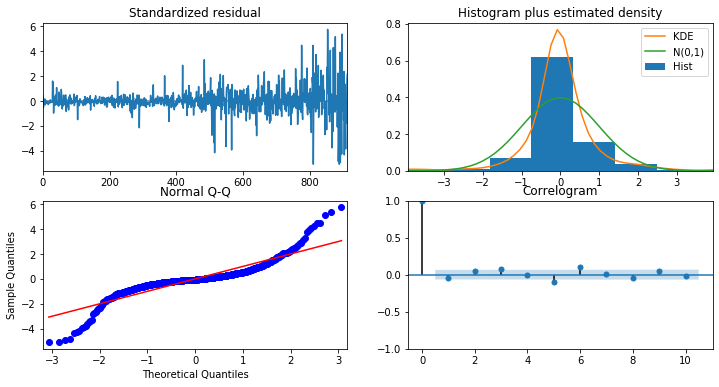

In [54]:
# Running auto_arima
auto_model = pm.auto_arima(y=Train['Close'], start_p=0, start_q=0, max_p=5, max_q=5, m=1,
                           seasonal=False, max_order=None,trace=True)

# Plotting auto_arima summary
display(auto_model.summary())

# Plotting auto_arima diagnostics
auto_model.plot_diagnostics(figsize=(12,6));

### Auto Arima on logged data

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2901.216, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2899.510, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2899.470, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2900.119, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2899.325, Time=0.96 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.011 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  915
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1452.608
Date:                Fri, 18 Jun 2021   AIC                          -2901.216
Time:                        17:02:12   BIC                          -2891.580
Sample:                             0   HQIC                         -2897.538
                                - 915                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.002      1.711      0.087      -0.000       0.006
sigma2         0.0024   4.63e-05     52.634      0.000       0.002       0.003
===================================================================================
Ljung-Box (Q):                       26.54   Jarque-Bera (JB):              4591.23
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

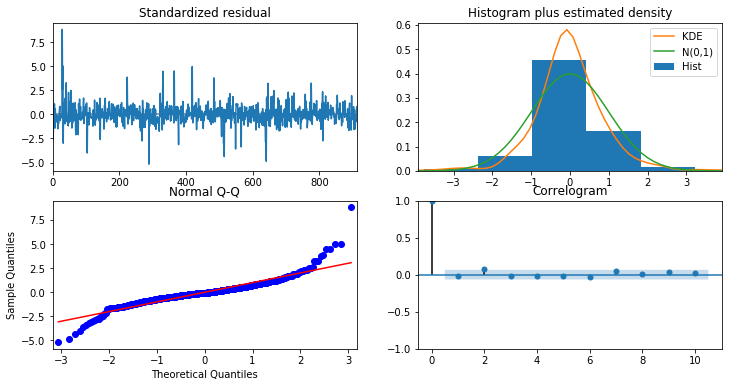

In [55]:
# Running auto_arima
auto_model = pm.auto_arima(y=Train['Close_logged'], start_p=0, start_q=0, max_p=5, max_q=5, m=1,
                           seasonal=False, max_order=None,trace=True)

# Plotting auto_arima summary
display(auto_model.summary())

# Plotting auto_arima diagnostics
auto_model.plot_diagnostics(figsize=(12,6));

The scores of the AIC look very close together, to further investigate we're going to check the parameters manually.

### Checking stationarity with diff 1 on raw and logged data.

In [56]:
Train_Close_diff1 = Train['Close'].diff(1).dropna()

print("Results of dickey fuller test for raw data")
adft = adfuller(Train_Close_diff1, autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test for raw data
Test Statistics               -1.166207e+01
p-value                        1.922711e-21
No. of lags used               5.000000e+00
Number of observations used    9.080000e+02
critical value (1%)           -3.437572e+00
critical value (5%)           -2.864728e+00
critical value (10%)          -2.568468e+00
dtype: float64


In [57]:
Train_Close_logged_diff1 = Train['Close_logged'].diff(1).dropna()

print("Results of dickey fuller test for logged data")
adft = adfuller(Train_Close_logged_diff1, autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test for logged data
Test Statistics                -19.838305
p-value                          0.000000
No. of lags used                 1.000000
Number of observations used    912.000000
critical value (1%)             -3.437541
critical value (5%)             -2.864714
critical value (10%)            -2.568460
dtype: float64


A difference of 1 will makes both time series stationary.

### PACF and ACF plots

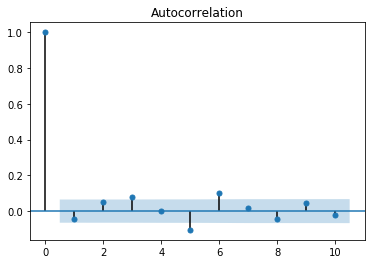

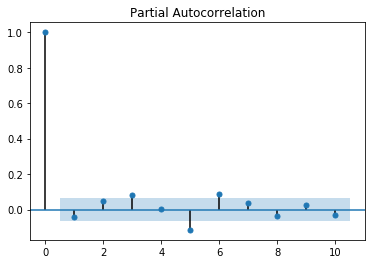

In [58]:
plot_acf(Train_Close_diff1, lags=10);
plot_pacf(Train_Close_diff1, lags=10);

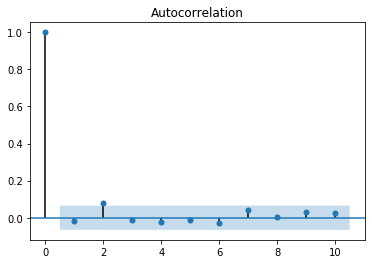

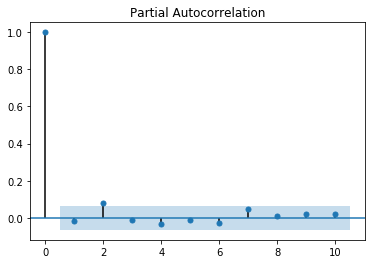

In [59]:
plot_acf(Train_Close_logged_diff1, lags=10);
plot_pacf(Train_Close_logged_diff1, lags=10);

### Trying order list found from PACF and ACF

In [60]:
# Trying different sets of parameters on raw data
order_list = [(0,1,0),(3,1,0),(0,1,3),(3,1,3)]

possible_params = Grid_Auto_bot(data = Train['Close'], order_list=order_list)
print('This is for the raw data')

# Ordering the parameters by aic
possible_params.sort_values(by='aic', ascending=True, inplace=True)
raw_order_1 = possible_params.iloc[0]['pdq']
raw_order_2 = possible_params.iloc[1]['pdq']
possible_params.head()

ARIMA (0, 1, 0) : AIC Calculated =5953.895644708036
ARIMA (3, 1, 0) : AIC Calculated =5949.68977108958
ARIMA (0, 1, 3) : AIC Calculated =5948.955462646896
ARIMA (3, 1, 3) : AIC Calculated =5943.534617338886
This is for the raw data


,pdq,aic
3,"(3, 1, 3)",5943.534617
2,"(0, 1, 3)",5948.955463
1,"(3, 1, 0)",5949.689771
0,"(0, 1, 0)",5953.895645


In [61]:
# Trying different set of params on logged data
order_list = [(0,1,0),(2,1,0),(0,1,2),(2,1,2)]

possible_params = Grid_Auto_bot(data = Train['Close_logged'], order_list=order_list)
print('This is for the logged data')

# Ordering the parameters by aic
possible_params.sort_values(by='aic', ascending=True, inplace=True)
logged_order_1 = possible_params.iloc[0]['pdq']
logged_order_2 = possible_params.iloc[1]['pdq']
possible_params.head()

ARIMA (0, 1, 0) : AIC Calculated =-2901.2158476591285
ARIMA (2, 1, 0) : AIC Calculated =-2903.1120810927787
ARIMA (0, 1, 2) : AIC Calculated =-2903.375066834674
ARIMA (2, 1, 2) : AIC Calculated =-2899.5894608297785
This is for the logged data


,pdq,aic
2,"(0, 1, 2)",-2903.375067
1,"(2, 1, 0)",-2903.112081
0,"(0, 1, 0)",-2901.215848
3,"(2, 1, 2)",-2899.589461


### ARIMA modeling using the new parameters

#### RAW DATA

##### First Parameter

In [62]:
# Making the train SARIMAX model
Train_model = ARIMA(Train['Close'],
                      order=raw_order_1,
                      freq='B')
train_output = Train_model.fit()
    
# Shows the train model summary
print('Train_model summary')
display(train_output.summary());

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  914
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -2963.767
Method:                       css-mle   S.D. of innovations              6.194
Date:                Fri, 18 Jun 2021   AIC                           5943.535
Time:                        17:02:18   BIC                           5982.077
Sample:                    09-29-2017   HQIC                          5958.247
                         - 03-31-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3316      0.220      1.505      0.133      -0.100       0.763
ar.L1.D.Close    -0.0725      0.297     -0.244      0.807      -0.655       0.510
ar.L2.D.Close    -0.5268      0.177     -2.969      0.003      -0.874      -0.179
ar.L3.D.Close     0.2580      0.229      1.128      0.260      -0.190       0.706
ma.L1.D.Close     0.0325      0.302      0.108      0.914      -0.560       0.625
ma.L2.D.Close     0.5797      0.179      3.246      0.001       0.230       0.930
ma.L3.D.Close    -0.1698      0.231     -0.736      0.462      -0.622       0.283
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3213           -1.1579j            1.2016           -0.2931
AR.2           -0.3213           +1.1579j            1.2016            0.2931
AR.3            2.6842           -0.0000j            2.6842           -0.0000
MA.1           -0.2225           -1.2151j            1.2353           -0.2788
MA.2           -0.2225           +1.2151j            1.2353            0.2788
MA.3            3.8587           -0.0000j            3.8587           -0.0000
-----------------------------------------------------------------------------
"""

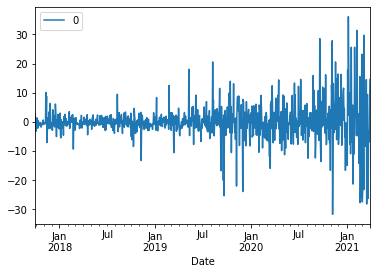

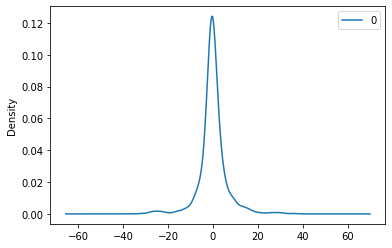

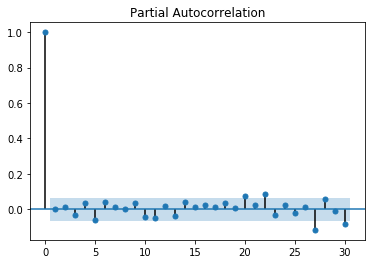

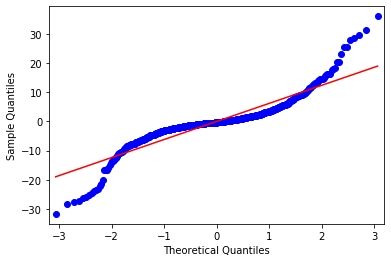

In [63]:
# Plotting the residuals for the model
residuals = pd.DataFrame(train_output.resid)



residuals.plot()

residuals.plot(kind='kde')

plot_pacf(residuals);

qqplot(train_output.resid,line='s');

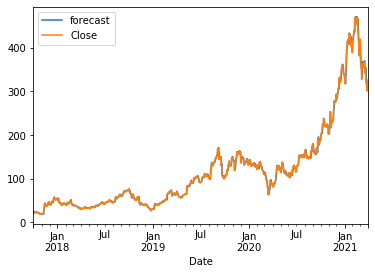

In [67]:
train_output.plot_predict();

In [69]:
len(Train)-42

873

In [106]:
# Split train data to a subset test data to see how well it predicts
# Subset test data will be 42 units
Train_train = Train['Close'][:917]
Train_test = Train['Close'][917:]

In [108]:
Train_test

Date
2021-04-05    328.290009
2021-04-06    359.369995
2021-04-07    361.920013
2021-04-08    372.679993
2021-04-09    373.660004
2021-04-12    371.119995
2021-04-13    387.970001
2021-04-14    374.660004
2021-04-15    388.640015
2021-04-16    376.519989
2021-04-19    361.149994
2021-04-20    354.850006
2021-04-21    356.619995
2021-04-22    350.059998
2021-04-23    356.869995
2021-04-26    368.630005
2021-04-27    360.649994
2021-04-28    357.739990
2021-04-29    356.700012
2021-04-30    342.970001
Freq: B, Name: Close, dtype: float64

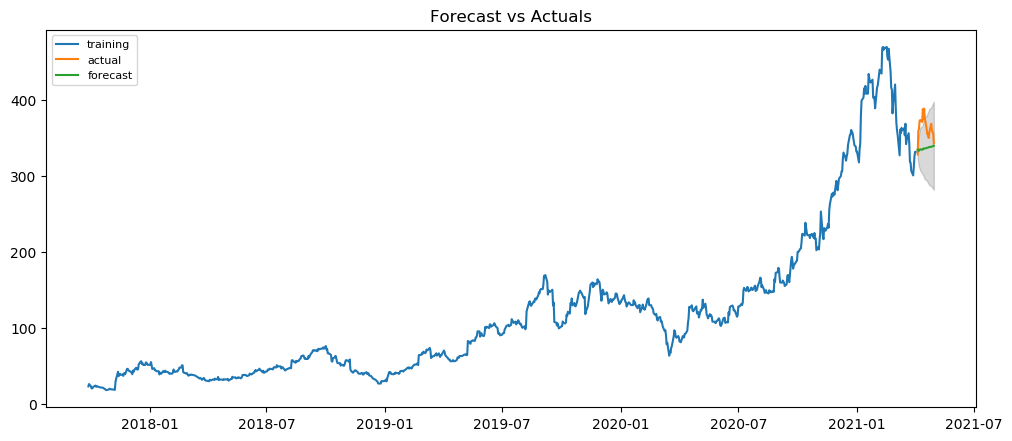

In [109]:
model = ARIMA(Train_train, order=raw_order_1)  
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(20, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=Train_test.index)
lower_series = pd.Series(conf[:, 0], index=Train_test.index)
upper_series = pd.Series(conf[:, 1], index=Train_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Train_train, label='training')
plt.plot(Train_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [110]:
# Get the error
fc_series

Date
2021-04-05    334.701021
2021-04-06    333.545177
2021-04-07    333.111609
2021-04-08    334.900214
2021-04-09    335.150199
2021-04-12    334.550634
2021-04-13    335.370161
2021-04-14    336.133407
2021-04-15    335.953740
2021-04-16    336.232120
2021-04-19    336.948747
2021-04-20    337.157969
2021-04-21    337.294629
2021-04-22    337.809338
2021-04-23    338.205053
2021-04-26    338.396194
2021-04-27    338.759556
2021-04-28    339.185578
2021-04-29    339.466337
2021-04-30    339.769122
Freq: B, dtype: float64

##### Second parameter

##### Final Model

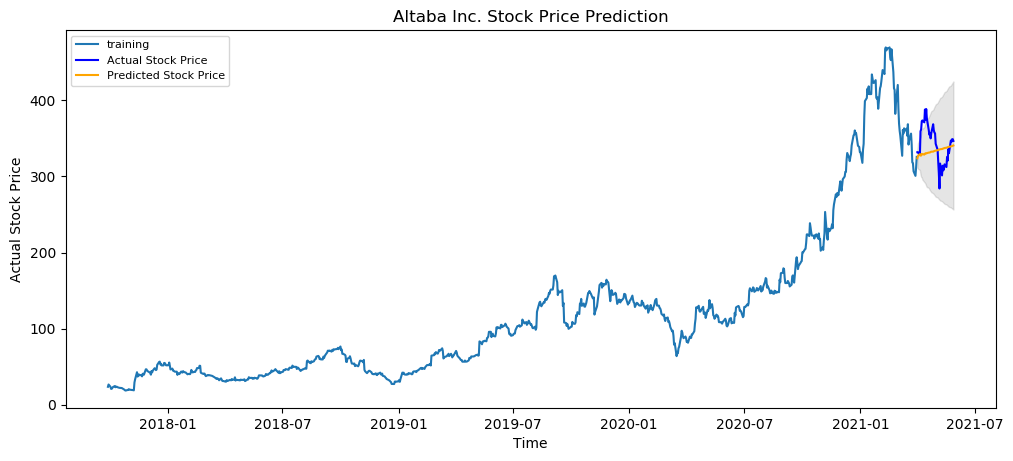

In [68]:
#Getting forecast to see how well the train model does compared to the test data
fc, se, conf = train_output.forecast(22, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=Test.index)
lower_series = pd.Series(conf[:, 0], index=Test.index)
upper_series = pd.Series(conf[:, 1], index=Test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Train['Close'], label='training')
plt.plot(Test['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [63]:
# Getting One Step prediction to check train model
train_prediction = train_output.get_prediction(start='2021-02-01',
                                               end='2021-03-31',
                                               dynamic=False)
train_prediction_conf = train_prediction.conf_int()
    
# Getting dynamic prediction to check train model
train_prediction_dyn = train_output.get_prediction(start='2021-02-01', 
                                                   end='2021-03-31', 
                                                   dynamic=True)
train_prediction_dyn_conf = train_prediction_dyn.conf_int()
    
#Getting forecast to see how well the train model does compared to the test data
train_forecast = train_output.get_forecast(steps = 42)
train_forecast_conf = train_forecast.conf_int()

    
# Plots the predictions from the train model
PlotPredictions(obs_data=Train['Close'],
                beg='2020-01-01',
                pred_data=train_prediction, 
                pred_data_conf=train_prediction_conf,
                title='Train one step prediction')

PlotPredictions(obs_data=Train['Close'], 
                beg='2020-01-01',
                pred_data=train_prediction_dyn, 
                pred_data_conf=train_prediction_dyn_conf,
                title='Train dynamic prediction')
PlotPredictions(obs_data=Final_df['Close'], 
                beg='2020-01-01',
                pred_data=train_forecast, 
                pred_data_conf=train_forecast_conf,
                title='Train forecasted test prediction')

AttributeError: 'ARIMAResults' object has no attribute 'get_prediction'

#### LOGGED DATA

In [81]:
# def Final_Model_Check(train, test, order, seasonal_order, beg='2017', train_check_start='2021-02-01',
#             train_check_end='2021-03-31', final_check_start='2021-04-01',
#             final_check_end='2021-05-31', future=30):


# Making the train SARIMAX model

Train_model = ARIMA(Train['Close_logged'],
                      order=(0,1,2),
                      freq='B')
train_output = Train_model.fit()
    
# Shows the train model summary
print('Train_model summary')
display(train_output.summary());

# Shows the diagnostics for the train model
#train_output.plot_diagnostics(figsize=(15,8));

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Close_logged   No. Observations:                  914
Model:                 ARIMA(0, 1, 2)   Log Likelihood                1455.688
Method:                       css-mle   S.D. of innovations              0.049
Date:                Thu, 17 Jun 2021   AIC                          -2903.375
Time:                        22:42:27   BIC                          -2884.104
Sample:                    09-29-2017   HQIC                         -2896.019
                         - 03-31-2021                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0029      0.002      1.659      0.098      -0.001       0.006
ma.L1.D.Close_logged    -0.0156      0.033     -0.473      0.636      -0.080       0.049
ma.L2.D.Close_logged     0.0828      0.034      2.447      0.015       0.016       0.149
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.0944           -3.4734j            3.4746           -0.2457
MA.2            0.0944           +3.4734j            3.4746            0.2457
-----------------------------------------------------------------------------
"""

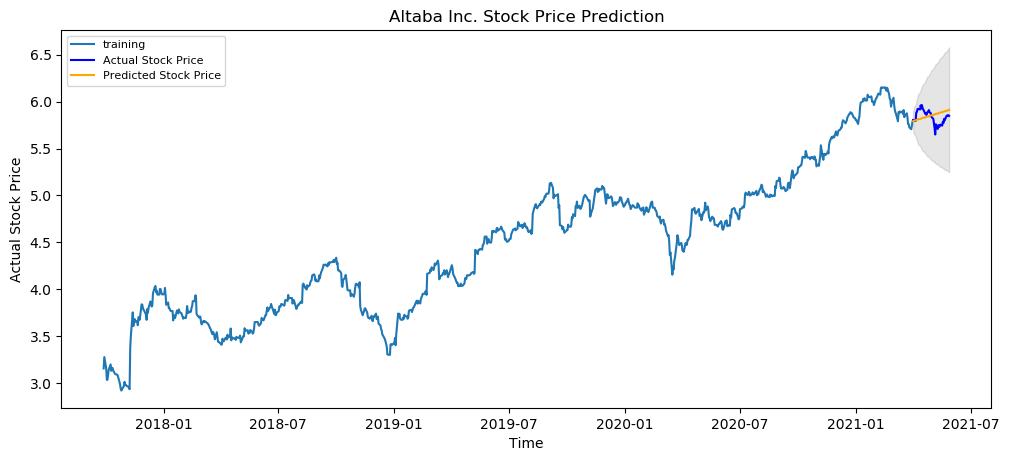

In [83]:
#Getting forecast to see how well the train model does compared to the test data
fc, se, conf = train_output.forecast(42, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=Test.index)
lower_series = pd.Series(conf[:, 0], index=Test.index)
upper_series = pd.Series(conf[:, 1], index=Test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Train['Close_logged'], label='training')
plt.plot(Test['Close_logged'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

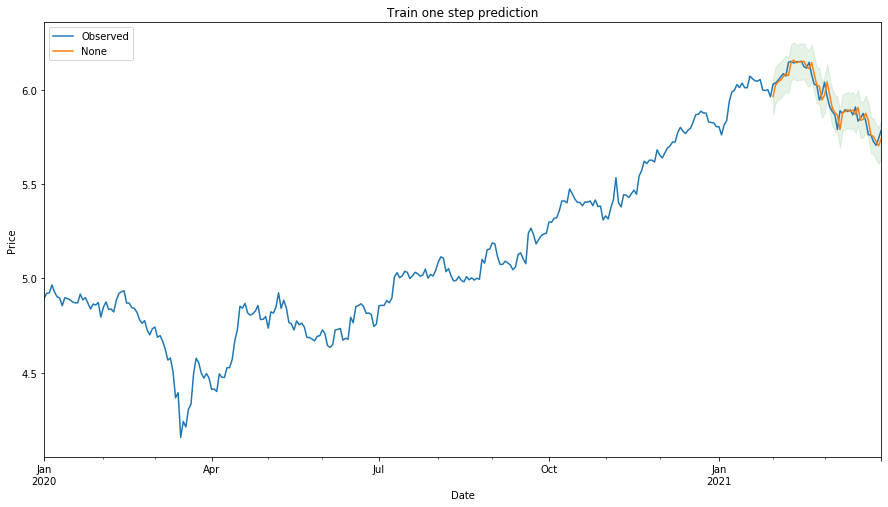

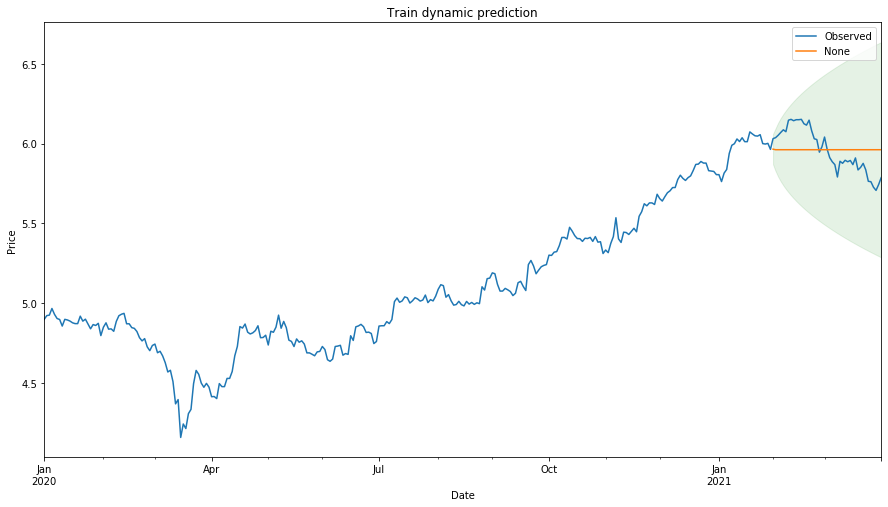

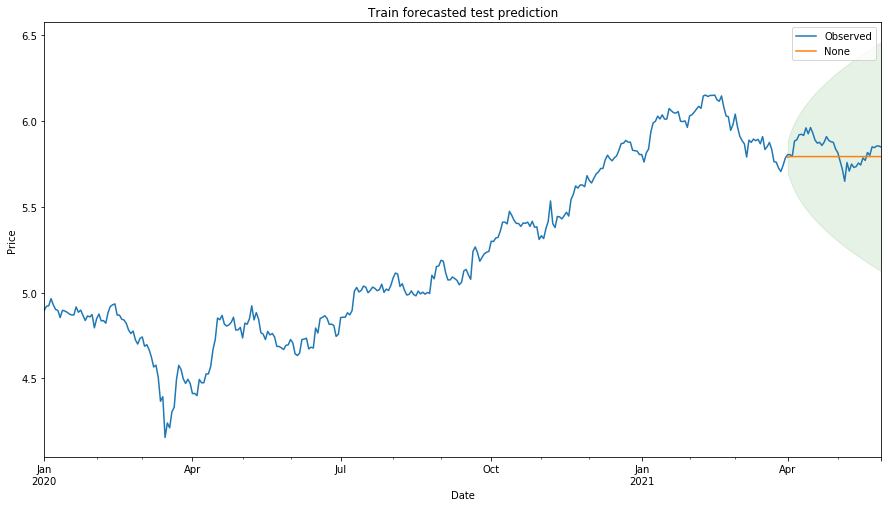

In [133]:
# Getting One Step prediction to check train model
train_prediction = train_output.get_prediction(start='2021-02-01',
                                               end='2021-03-31',
                                               dynamic=False)
train_prediction_conf = train_prediction.conf_int()
    
# Getting dynamic prediction to check train model
train_prediction_dyn = train_output.get_prediction(start='2021-02-01', 
                                                   end='2021-03-31', 
                                                   dynamic=True)
train_prediction_dyn_conf = train_prediction_dyn.conf_int()
    
#Getting forecast to see how well the train model does compared to the test data
train_forecast = train_output.get_forecast(steps = 42)
train_forecast_conf = train_forecast.conf_int()

    
# Plots the predictions from the train model
PlotPredictions(obs_data=Train['Close_logged'],
                beg='2020-01-01',
                pred_data=train_prediction, 
                pred_data_conf=train_prediction_conf,
                title='Train one step prediction')

PlotPredictions(obs_data=Train['Close_logged'], 
                beg='2020-01-01',
                pred_data=train_prediction_dyn, 
                pred_data_conf=train_prediction_dyn_conf,
                title='Train dynamic prediction')
PlotPredictions(obs_data=Final_df['Close_logged'], 
                beg='2020-01-01',
                pred_data=train_forecast, 
                pred_data_conf=train_forecast_conf,
                title='Train forecasted test prediction')

In [ ]:
# Figure this out later

#     # Calculating MSE for all predictions/forecast for train model
#     train_mse = mse_calc(data=train, prediction=train_prediction, 
#                          start=train_check_start)
#     train_dyn_mse = mse_calc(data=train, prediction=train_prediction_dyn, 
#                              start=train_check_start)
#     train_forecast_mse = mse_calc(data=data, prediction=train_forecast, 
#                                   start=final_check_start)
#     train_forecast_rmse = np.sqrt(train_forecast_mse)

In [ ]:

#     # Final model that's going to predict the future using both train + test
#     Final_model = SARIMAX(data['value'].astype('int'),
#                     order=order,
#                     seasonal_order=seasonal_order,
#                     enforce_invertibility=False,
#                     enforce_stationarity=False)
#     Final_output = Final_model.fit()
    
#     # Shows the final models summary
#     print('Final_output summary')
#     display(Final_output.summary());
 

#     # Getting One Step prediction to check Final model
#     final_prediction = Final_output.get_prediction(start=final_check_start,
#                                            end=final_check_end,
#                                            dynamic=False)
#     final_prediction_conf = final_prediction.conf_int()
    
#     # Getting dynamic prediction to check Final model
#     final_prediction_dyn = Final_output.get_prediction(start=final_check_start, 
#                                                      end=final_check_end, 
#                                                      dynamic=True)
#     final_prediction_dyn_conf = final_prediction_dyn.conf_int()
    
#     #Getting future forecast for the final model
#     final_forecast = Final_output.get_forecast(steps = future)
#     final_forecast_conf = final_forecast.conf_int()

    
#     # Calculating MSE for all predictions for final model
#     final_mse = mse_calc(data=data, prediction=final_prediction, 
#                          start=final_check_start)
#     final_dyn_mse = mse_calc(data=data, prediction=final_prediction_dyn, 
#                              start=final_check_start)
#     final_dyn_rmse = np.sqrt(final_dyn_mse)
    
#     # Shows the diagnostics for the final model
#     Final_output.plot_diagnostics();
    
#     # Plots the future predictions for the final model
#     PlotPredictions(obs_data=data,
#                     beg=beg,
#                     pred_data=final_forecast, 
#                     pred_data_conf=final_forecast_conf,
#                     title='Final forecast')

In [ ]:

#def PlotPredictions(obs_data, pred_data, pred_data_conf, beg='2013', title='title'):
    
# Plot observed values
ax = Train['Close_logged'].plot(label='Observed')

# Plot predicted values
train_prediction.predicted_mean.plot(ax=ax)

# Plot the range for confidence intervals
ax.fill_between(train_prediction_conf.index,
                train_prediction_conf.iloc[:, 0],
                train_prediction_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_title('title')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()





#     PlotPredictions(obs_data=data, 
#                     beg=beg,
#                     pred_data=train_prediction_dyn, 
#                     pred_data_conf=train_prediction_dyn_conf,
#                     title='Train dynamic prediction')
#     PlotPredictions(obs_data=data, 
#                     beg=beg,
#                     pred_data=train_forecast, 
#                     pred_data_conf=train_forecast_conf,
#                     title='Train forecasted test prediction')

        
#     # Calculating MSE for all predictions/forecast for train model
#     train_mse = mse_calc(data=train, prediction=train_prediction, 
#                          start=train_check_start)
#     train_dyn_mse = mse_calc(data=train, prediction=train_prediction_dyn, 
#                              start=train_check_start)
#     train_forecast_mse = mse_calc(data=data, prediction=train_forecast, 
#                                   start=final_check_start)
#     train_forecast_rmse = np.sqrt(train_forecast_mse)
    
    
#     # Final model that's going to predict the future using both train + test
#     Final_model = SARIMAX(data['value'].astype('int'),
#                     order=order,
#                     seasonal_order=seasonal_order,
#                     enforce_invertibility=False,
#                     enforce_stationarity=False)
#     Final_output = Final_model.fit()
    
#     # Shows the final models summary
#     print('Final_output summary')
#     display(Final_output.summary());
 

#     # Getting One Step prediction to check Final model
#     final_prediction = Final_output.get_prediction(start=final_check_start,
#                                            end=final_check_end,
#                                            dynamic=False)
#     final_prediction_conf = final_prediction.conf_int()
    
#     # Getting dynamic prediction to check Final model
#     final_prediction_dyn = Final_output.get_prediction(start=final_check_start, 
#                                                      end=final_check_end, 
#                                                      dynamic=True)
#     final_prediction_dyn_conf = final_prediction_dyn.conf_int()
    
#     #Getting future forecast for the final model
#     final_forecast = Final_output.get_forecast(steps = future)
#     final_forecast_conf = final_forecast.conf_int()

    
#     # Calculating MSE for all predictions for final model
#     final_mse = mse_calc(data=data, prediction=final_prediction, 
#                          start=final_check_start)
#     final_dyn_mse = mse_calc(data=data, prediction=final_prediction_dyn, 
#                              start=final_check_start)
#     final_dyn_rmse = np.sqrt(final_dyn_mse)
    
#     # Shows the diagnostics for the final model
#     Final_output.plot_diagnostics();
    
#     # Plots the future predictions for the final model
#     PlotPredictions(obs_data=data,
#                     beg=beg,
#                     pred_data=final_forecast, 
#                     pred_data_conf=final_forecast_conf,
#                     title='Final forecast')

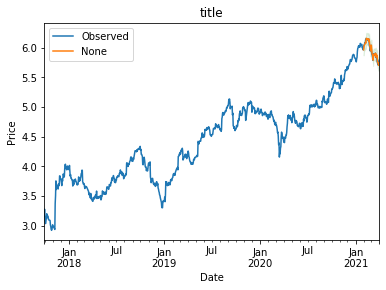

In [76]:
ax = Train['Close_logged'].plot(label='Observed')
train_prediction.predicted_mean.plot(ax=ax)

# Plot the range for confidence intervals
ax.fill_between(train_prediction_conf.index,
                train_prediction_conf.iloc[:, 0],
                train_prediction_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_title('title')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

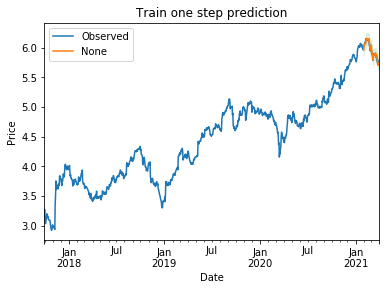

In [78]:
PlotPredictions(obs_data=Train['Close_logged'],
                beg='2017-09-01',
                pred_data=train_prediction, 
                pred_data_conf=train_prediction_conf,
                title='Train one step prediction')


In [122]:
Train.index

DatetimeIndex(['2017-09-28', '2017-09-29', '2017-10-02', '2017-10-03',
               '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-09',
               '2017-10-10', '2017-10-11',
               ...
               '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23',
               '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='Date', length=915, freq='B')

# Testing

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Close   No. Observations:                  915
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -2953.942
Date:                Fri, 18 Jun 2021   AIC                           5921.883
Time:                        16:24:03   BIC                           5955.577
Sample:                    09-28-2017   HQIC                          5934.748
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0569      0.225     -0.253      0.801      -0.499       0.385
ar.L2         -0.4865      0.091     -5.354      0.000      -0.665      -0.308
ar.L3          0.2788      0.182      1.528      0.127      -0.079       0.636
ma.L1          0.0192      0.232      0.083      0.934      -0.435       0.473
ma.L2          0.5414      0.086      6.279      0.000       0.372       0.710
ma.L3         -0.1828      0.196     -0.932      0.351      -0.567       0.202
sigma2        38.6221      0.855     45.181      0.000      36.947      40.298
===================================================================================
Ljung-Box (Q):                       63.53   Jarque-Bera (JB):              2302.59
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              16.60   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

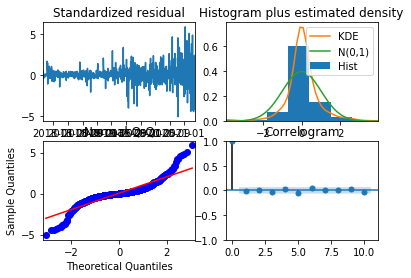

In [102]:
Train_model = SARIMAX(Train['Close'],
                      order=(3,1,3),
                      freq='B',
                      enforce_invertibility=False,
                      enforce_stationarity=False)
train_output = Train_model.fit()

# Shows the train model summary
print('Train_model summary')
display(train_output.summary());

train_output.plot_diagnostics();

/Users/stevenkyle/opt/anaconda3/envs/Capstone/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1095: UserWarning: Attempting to set identical left == right == 13369.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


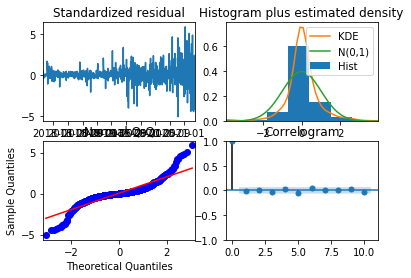

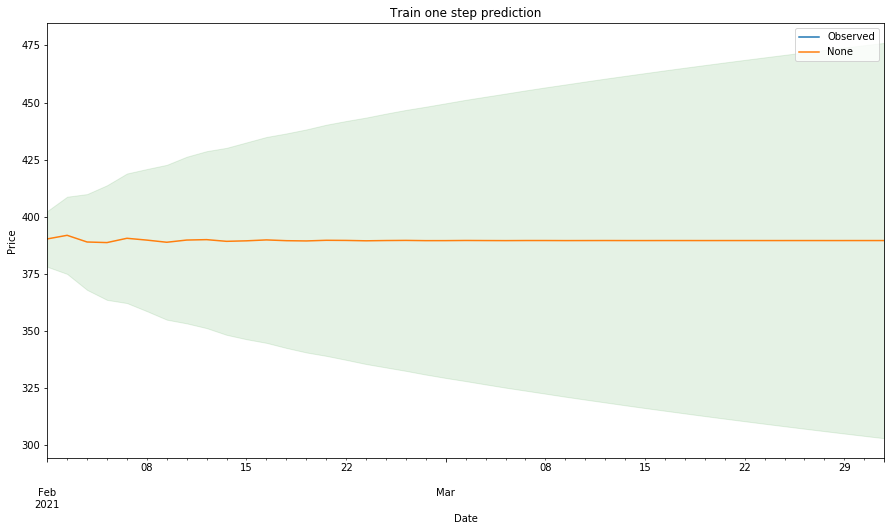

In [107]:
# Getting One Step prediction to check train model
train_prediction = train_output.get_prediction(start='2021-02-01',
                                               end='2021-03-31',
                                               dynamic=True)
train_prediction_conf = train_prediction.conf_int()
    

    
# Shows the diagnostics for the train model
train_output.plot_diagnostics();
    
# Plots the predictions from the train model
PlotPredictions(obs_data=Train['Close'],
                beg='2021-03-31',
                pred_data=train_prediction, 
                pred_data_conf=train_prediction_conf,
                title='Train one step prediction')

In [ ]:
# Shows the train model summary
print('Train_model summary')
display(train_output.summary());
    
    # Getting One Step prediction to check train model
    train_prediction = train_output.get_prediction(start=train_check_start,
                                           end=train_check_end,
                                           dynamic=False)
    train_prediction_conf = train_prediction.conf_int()
    
    # Getting dynamic prediction to check train model
    train_prediction_dyn = train_output.get_prediction(start=train_check_start, 
                                                     end=train_check_end, 
                                                     dynamic=True)
    train_prediction_dyn_conf = train_prediction_dyn.conf_int()
    
    #Getting forecast to see how well the train model does compared to the test data
    train_forecast = train_output.get_forecast(steps = 42)
    train_forecast_conf = train_forecast.conf_int()
    
    # Shows the diagnostics for the train model
    train_output.plot_diagnostics();
    
    # Plots the predictions from the train model
    PlotPredictions(obs_data=train,
                    beg=beg,
                    pred_data=train_prediction, 
                    pred_data_conf=train_prediction_conf,
                    title='Train one step prediction')
    PlotPredictions(obs_data=data, 
                    beg=beg,
                    pred_data=train_prediction_dyn, 
                    pred_data_conf=train_prediction_dyn_conf,
                    title='Train dynamic prediction')
    PlotPredictions(obs_data=data, 
                    beg=beg,
                    pred_data=train_forecast, 
                    pred_data_conf=train_forecast_conf,
                    title='Train forecasted test prediction')

        
    # Calculating MSE for all predictions/forecast for train model
    train_mse = mse_calc(data=train, prediction=train_prediction, 
                         start=train_check_start)
    train_dyn_mse = mse_calc(data=train, prediction=train_prediction_dyn, 
                             start=train_check_start)
    train_forecast_mse = mse_calc(data=data, prediction=train_forecast, 
                                  start=final_check_start)
    train_forecast_rmse = np.sqrt(train_forecast_mse)
    
    
    # Final model that's going to predict the future using both train + test
    Final_model = SARIMAX(data['value'].astype('int'),
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    Final_output = Final_model.fit()
    
    # Shows the final models summary
    print('Final_output summary')
    display(Final_output.summary());
 

    # Getting One Step prediction to check Final model
    final_prediction = Final_output.get_prediction(start=final_check_start,
                                           end=final_check_end,
                                           dynamic=False)
    final_prediction_conf = final_prediction.conf_int()
    
    # Getting dynamic prediction to check Final model
    final_prediction_dyn = Final_output.get_prediction(start=final_check_start, 
                                                     end=final_check_end, 
                                                     dynamic=True)
    final_prediction_dyn_conf = final_prediction_dyn.conf_int()
    
    #Getting future forecast for the final model
    final_forecast = Final_output.get_forecast(steps = future)
    final_forecast_conf = final_forecast.conf_int()

    
    # Calculating MSE for all predictions for final model
    final_mse = mse_calc(data=data, prediction=final_prediction, 
                         start=final_check_start)
    final_dyn_mse = mse_calc(data=data, prediction=final_prediction_dyn, 
                             start=final_check_start)
    final_dyn_rmse = np.sqrt(final_dyn_mse)
    
    # Shows the diagnostics for the final model
    Final_output.plot_diagnostics();
    
    # Plots the future predictions for the final model
    PlotPredictions(obs_data=data,
                    beg=beg,
                    pred_data=final_forecast, 
                    pred_data_conf=final_forecast_conf,
                    title='Final forecast')

In [110]:
 train_prediction_conf

,lower Close,upper Close
Date,,
2021-02-01,378.095093,402.456133
2021-02-02,374.956225,408.764559
2021-02-03,367.962900,409.910835
2021-02-04,363.589795,413.769217
2021-02-05,362.196175,418.920687
2021-02-08,358.647976,420.875227
2021-02-09,354.921380,422.720666
2021-02-10,353.304648,426.267577
2021-02-11,351.226799,428.706501


In [ ]:
# Order of things to do

# Look at rolling average
# autoarima DONE
# Check stationarity DONE
# Check pacf and acf curves DONE
# Try manual params DONE
# Check manual params on train set, include pictures
# Use manual params on test set, include pictures